In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [50]:
iris = load_iris()

In [51]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['species'] = df['target'].map({i : name for i, name in enumerate(iris.target_names)})

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   species            150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [53]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [54]:
df = df.rename(columns={
    'sepal length (cm)': 'sepal_length',
    'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length',
    'petal width (cm)': 'petal_width'
})

In [55]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
target          0
species         0
dtype: int64

In [56]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
target          0
species         0
dtype: int64

In [57]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Due to the min-max range we probably wouldn't need to standardize the data to get good results, but we will do it later nonetheless for good practice.

In [58]:
df['target'].value_counts() / len(df)

target
0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64

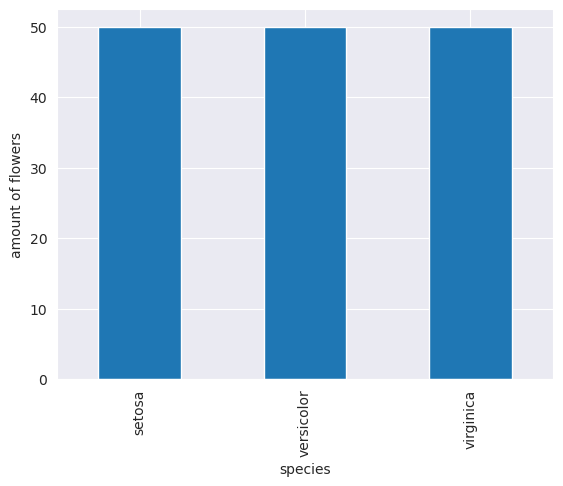

In [59]:
df['species'].value_counts().plot(kind='bar')
plt.ylabel('amount of flowers')
plt.show()

We can see from this that our dataset is perfectly balanced (all targets appear the same time). This helps us later with training our model.

In [60]:
df.duplicated().sum()

np.int64(1)

In [61]:
df[df.duplicated()]

,sepal_length,sepal_width,petal_length,petal_width,target,species
142,5.8,2.7,5.1,1.9,2,virginica


I won't remove this here as probably this is just another flower with the same features. And since the dataset is balanced I let it this way.

In [62]:
df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
target            int64
species          object
dtype: object

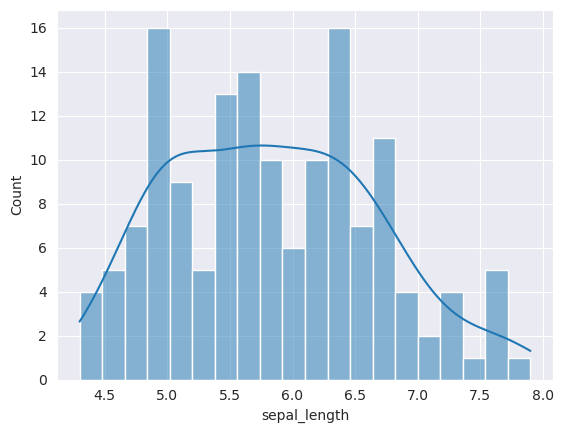

In [63]:
sns.histplot(df['sepal_length'], kde=True, bins=20)
plt.show()

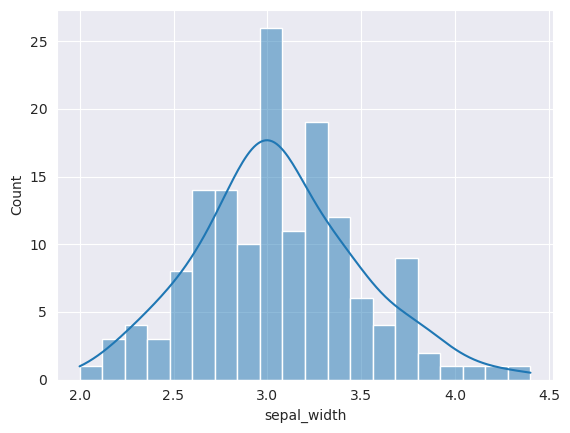

In [64]:
sns.histplot(df['sepal_width'], kde=True, bins=20)
plt.show()

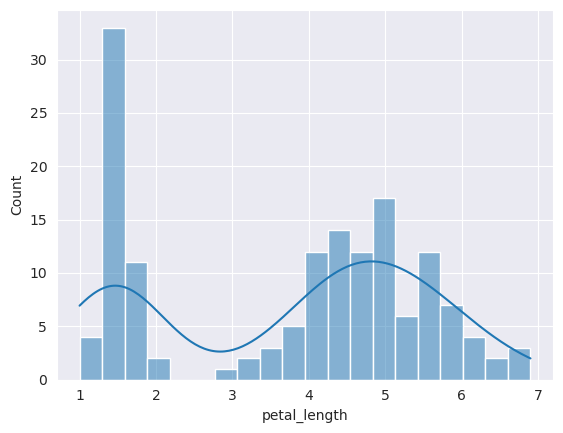

In [65]:
sns.histplot(df['petal_length'], kde=True, bins=20)
plt.show()

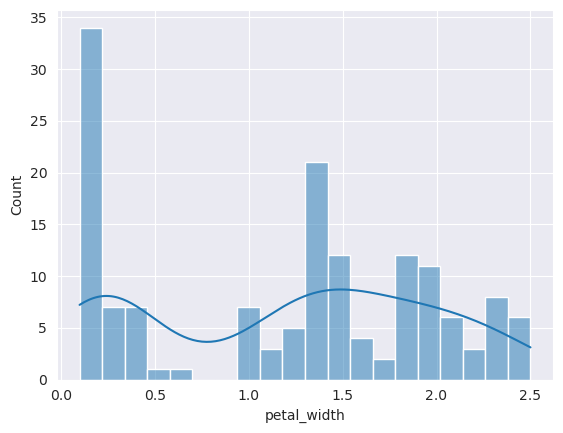

In [66]:
sns.histplot(df['petal_width'], kde=True, bins=20)
plt.show()

<Axes: >

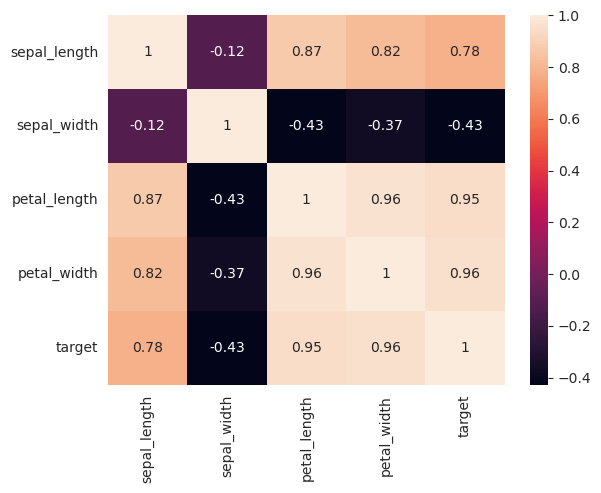

In [67]:
sns.heatmap(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']].corr(), annot=True)

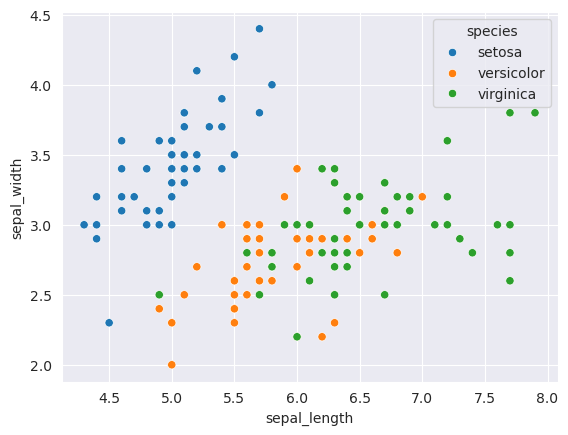

In [68]:
sns.scatterplot(df, x='sepal_length', y='sepal_width', hue='species')
plt.show()

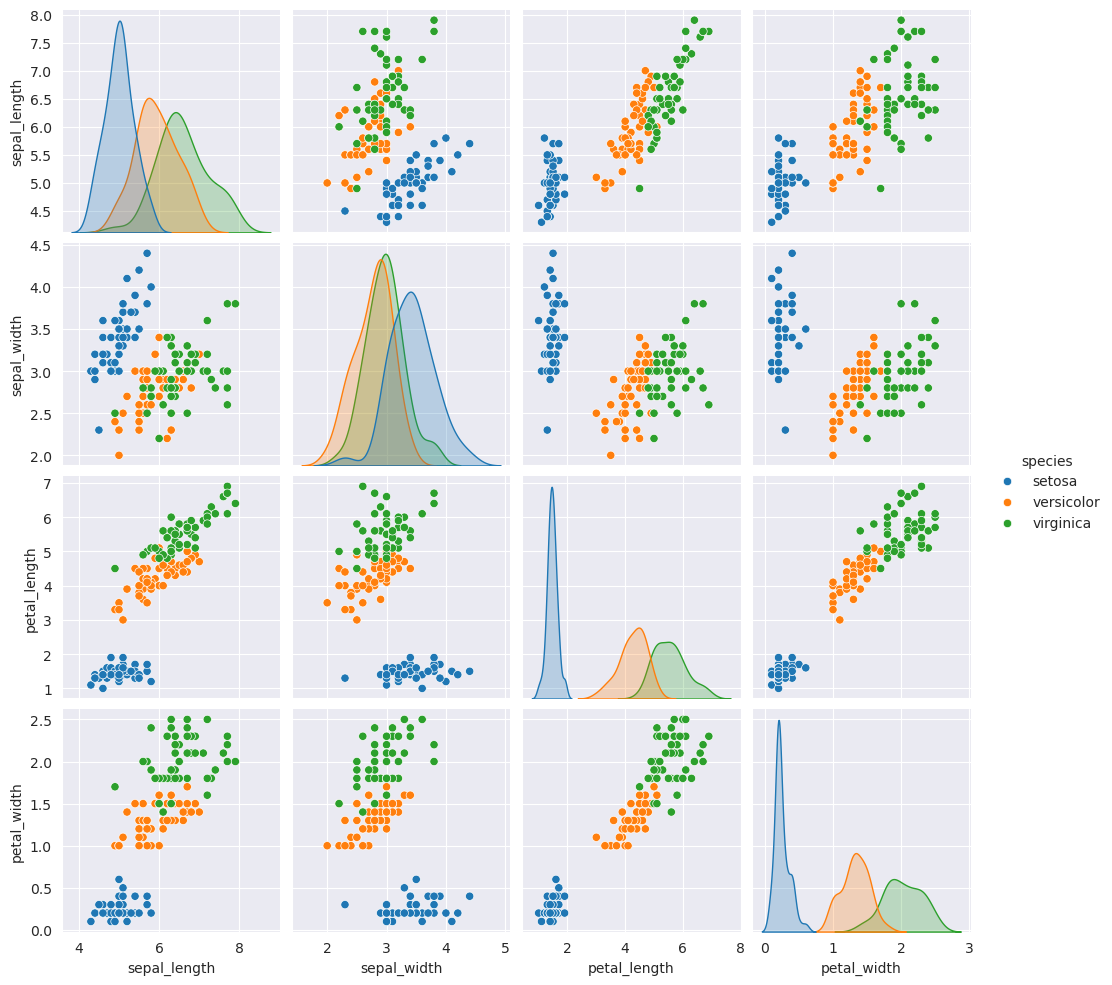

In [69]:
sns.pairplot(data=df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']], hue='species')
plt.show()

What we can observe here, is that the 'setosa' to the rest is always linear separable based on only two features. However, for the other two it is harder, and we need more than 2 features to classify the flowers correctly.
Here we can also see why there were multiple peaks in our uni variate analysis: Each peak was the result of one of the flowers. 

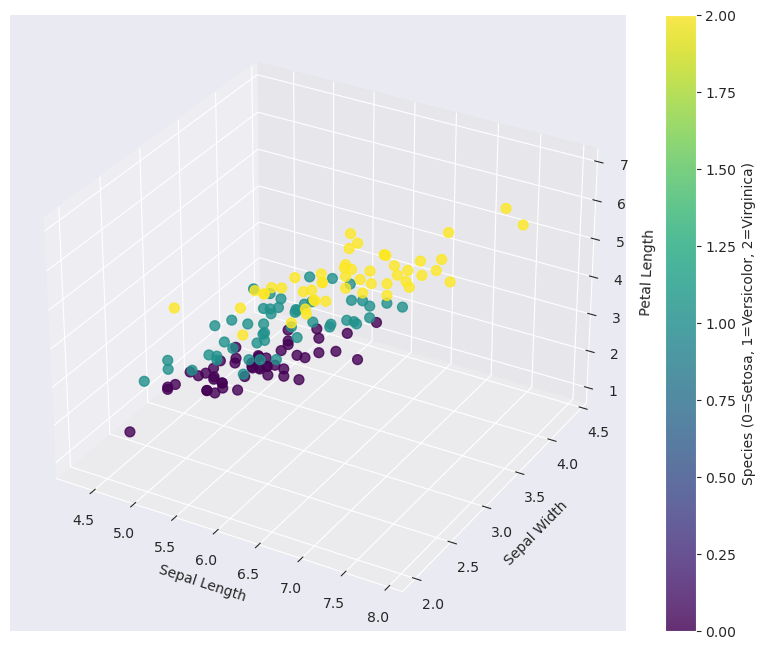

In [70]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['sepal_length']
y = df['sepal_width']
z = df['petal_length']

scatter = ax.scatter(x, y, z, c=df['target'], cmap='viridis', s=50, alpha=0.8)

ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
plt.colorbar(scatter, label='Species (0=Setosa, 1=Versicolor, 2=Virginica)')

plt.show()

We can see that in a 3D plot we can't really see if the flowers are linear separable or whether we need a basis function later on. So when we do logistic regression later on we will just hypertune the basis function and will stop here.

# Modeling

In [71]:
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## k-NN

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 31)}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_knn.fit(X_train_scaled, y_train)

print(f"Best K: {grid_knn.best_params_['n_neighbors']}")
print(f"Best CV Accuracy: {grid_knn.best_score_:.4f}")

Best K: 5
Best CV Accuracy: 0.9667


## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg_model = LogisticRegression(random_state=42)
scores = cross_val_score(logreg_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Best CV Accuracy: {scores.mean():.4f}")

Best CV Accuracy: 0.9583


In [74]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('logreg', LogisticRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4],
}

grid_logreg = GridSearchCV(pipeline, param_grid, cv=5)
grid_logreg.fit(X_train_scaled, y_train)

print(f"Best degree: {grid_logreg.best_params_['poly__degree']}")
print(f"Best CV Accuracy: {grid_logreg.best_score_:.4f}")


Best degree: 2
Best CV Accuracy: 0.9667


## Decision Tree

In [75]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0.0, 0.01, 0.04]
}

dec_tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(dec_tree, param_grid, cv=5)
grid_tree.fit(X_train_scaled, y_train)

print(f"Best CV Accuracy: {grid_tree.best_score_:.4f}")

Best CV Accuracy: 0.9500


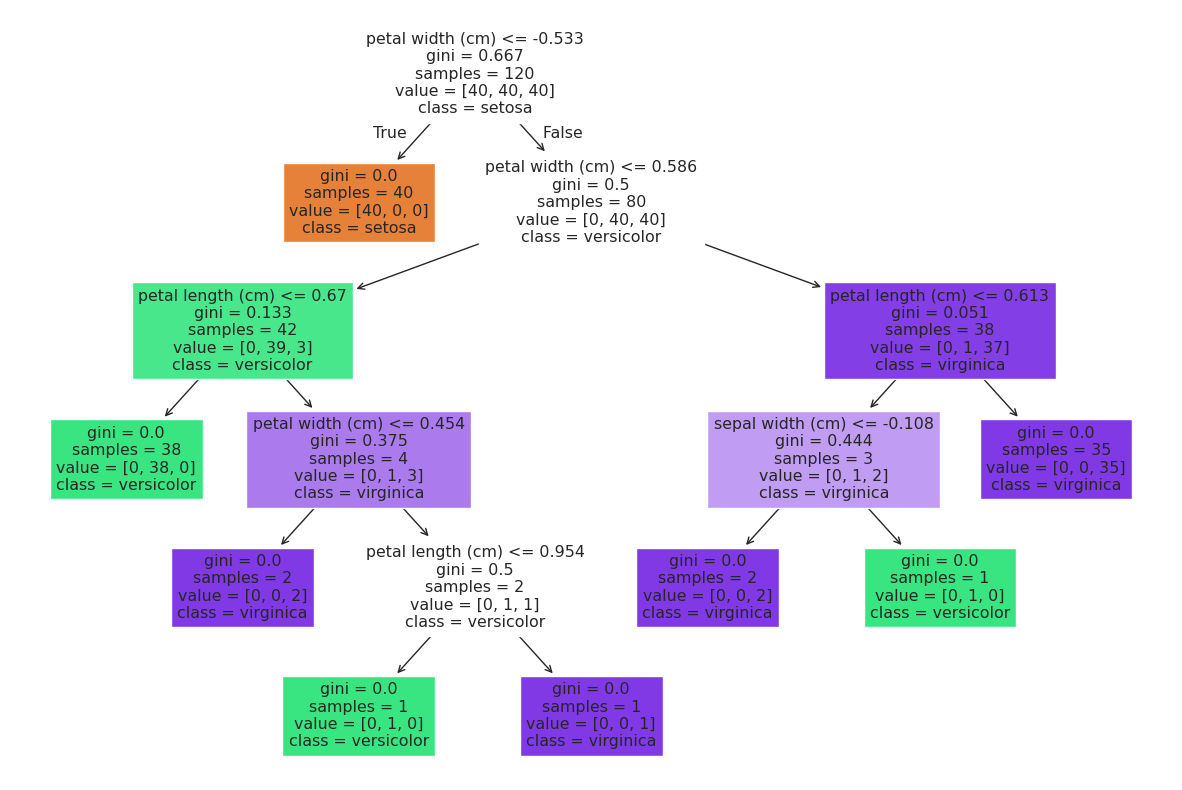

In [76]:
from sklearn.tree import plot_tree

best_tree = grid_tree.best_estimator_

plt.figure(figsize=(15, 10))
plot_tree(best_tree, feature_names=iris.feature_names,
          class_names=iris.target_names, filled=True)
plt.show()

### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0.0, 0.01, 0.04]
}

rnd_forest = RandomForestClassifier()
grid_forest = GridSearchCV(rnd_forest, param_grid, cv=5)
grid_forest.fit(X_train_scaled, y_train)

print(f"Best CV Accuracy: {grid_forest.best_score_:.4f}")

Best CV Accuracy: 0.9667


## Comparison

LogReg (Untuned): 0.9583 (+/-) 0.0264
LogReg (Grid): 0.9667 (+/-) 0.0312
Decision Tree: 0.9417 (+/-) 0.0204
KNN: 0.9667 (+/-) 0.0312
Random Forest: 0.9500 (+/-) 0.0167


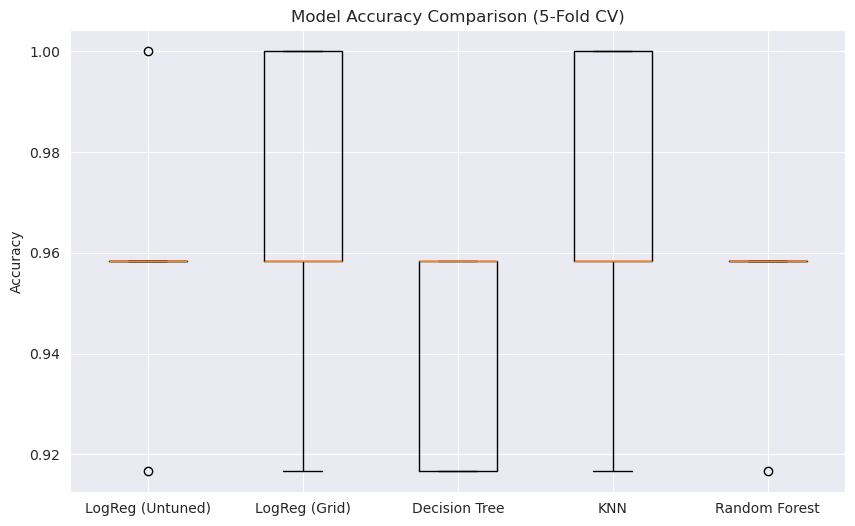

In [78]:
models = [
    ('LogReg (Untuned)', logreg_model.fit(X_train_scaled, y_train)),
    ('LogReg (Grid)', grid_logreg.best_estimator_),
    ('Decision Tree', grid_tree.best_estimator_),
    ('KNN', grid_knn.best_estimator_),
    ('Random Forest', grid_forest.best_estimator_)
]

results = []
names = []

for name, model in models:
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: {cv_scores.mean():.4f} (+/-) {cv_scores.std():.4f}")
    
plt.figure(figsize=(10, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Accuracy Comparison (5-Fold CV)')
plt.ylabel('Accuracy')
plt.show()

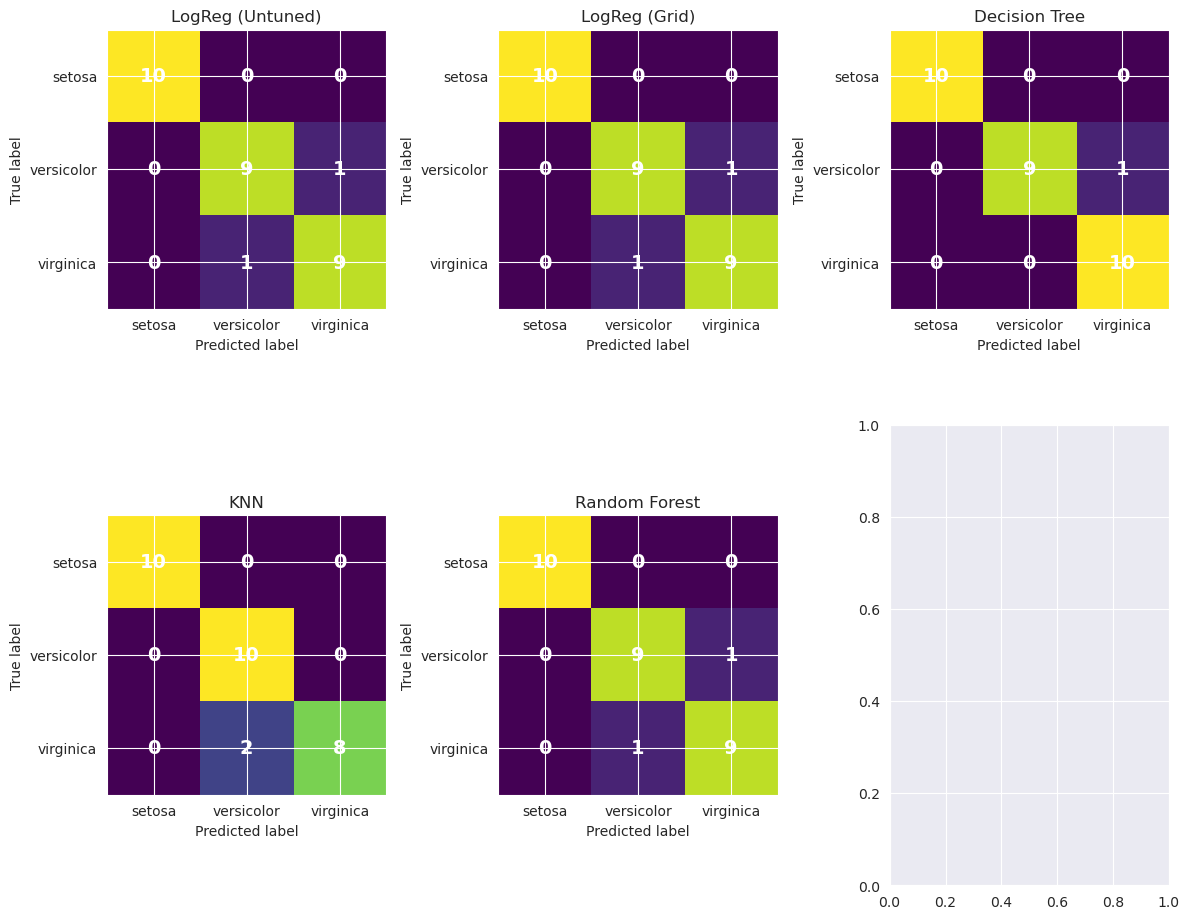

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models):
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_scaled, y_test,
        display_labels=iris.target_names,
        ax=axes[i],
        colorbar=False,
        text_kw={'color': 'white', 'fontsize': 14, 'fontweight': 'bold'}
    )
    axes[i].set_title(name)
    
plt.tight_layout()
plt.show()

Here we can see all the models generalize nearly the same. We can See that Logistic Regression (Untuned) and Logistic Regression (Grid) are identically, but from the boxplot above Logistic Regression (Grid) performed a little better. Between the others they are basically all the same it more depends on what you want. Do you need high precision, high recall .... However, we can see that Random Forest with a std of 0.0167 was the most stable model, which is also useful in some cases.

In [80]:
from sklearn.metrics import classification_report

y_pred = logreg_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [81]:
from sklearn.metrics import classification_report

y_pred = grid_logreg.best_estimator_.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [82]:
from sklearn.metrics import classification_report

y_pred = grid_tree.best_estimator_.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [83]:
from sklearn.metrics import classification_report

y_pred = grid_knn.best_estimator_.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [84]:
from sklearn.metrics import classification_report

y_pred = grid_forest.best_estimator_.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



From these classification reports we can deduce that if we want high precision the tree models (decision tree and random forest) perform the best, so we should use this if the cost for false positives is high (you might need one of the flowers for a medical application and can't afford to take the wrong flower). For recall, we should also choose the tree models. We should use this if the cost for False Negatives is high. If we want both we should use the f1-score were also the tree based models perform the best.
Thus, we can see that for this dataset a decision tree or/and random forest perform the best.